In [378]:
%load_ext autoreload
%autoreload 2
import time
import numpy as np
import warnings
from matplotlib.patches import Ellipse
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ExpSineSquared, Matern

from tests import *
from gridspace import gen_gridded_space_DET, parse_map_for_GP, plot_truth_features, plot_sampled_features
from gp import GaussianProcess
from sampler import AdaptiveSampling

warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Global constants
feature_scale = 2
feature_colors = [(0,1,0), (0,0,1)]
feature_dict = {
    1: (feature_colors[0], (Ellipse((-1.5, -1), 2.5, 6, 20),)), 
    2: (feature_colors[1], (Ellipse((1, 2), 8, 2, 170), Ellipse((2, -1), 6, 2, 60),))
}
feature_name_colors = (('Red', 'No Features'), ('Green', 'Feature 1'), ('Blue', 'Feature 2'))

plot_dict = {
    'feature_name_colors': feature_name_colors
}

feature_stats = [(0, 1), (6, 4), (5, 9)]

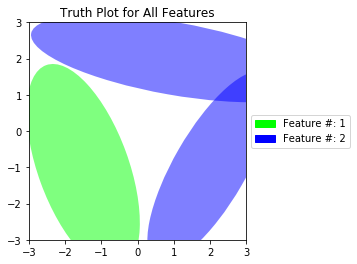

In [5]:
# plot truth features
plot_truth_features(feature_dict, oneFeature=False)

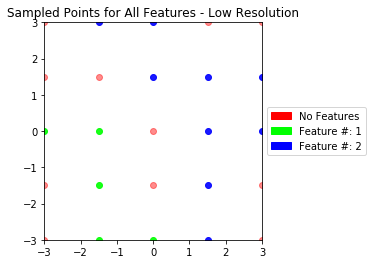

In [40]:
def test_low_resolution():
    # Test gridded representation of the features (low res, initial sample)
    N = 5
    X, Y, Z = gen_gridded_space_DET(feature_dict, N=N)

    plot_sampled_features(Z, feature_dict, N=N, titleStr='Sampled Points for All Features - Low Resolution')
    
test_low_resolution()

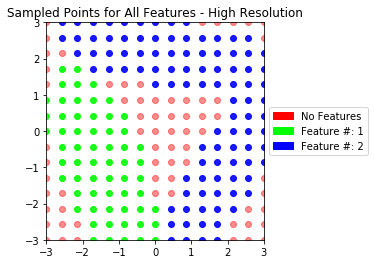

In [49]:
def test_high_resolution():
    # Test gridded representation of the features (low res, initial sample)
    N = 15
    X, Y, Z = gen_gridded_space_DET(feature_dict, N=N)

    plot_sampled_features(Z, feature_dict, N=N, plotNoFeatures=True,
                          titleStr='Sampled Points for All Features - High Resolution')
    
test_high_resolution()

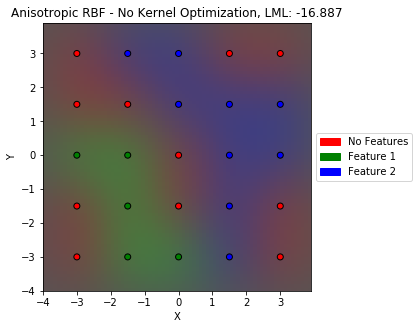

In [58]:
def test_gp(kernel, optimize, plot_dict, title, entropy=False):
    N = 5
    X, Y, Z = gen_gridded_space_DET(feature_dict, N=N)
    X_train, y_train = parse_map_for_GP(X, Y, Z)
    
    model = GaussianProcess(kernel, optimize, plot_dict)
    model.fit(X_train, y_train)
    if entropy:
        model.plot_entropy(title=title)
    else:
        model.plot_belief(title=title)

kernel = 1.0 * RBF([1.0, 1.0])
test_gp(kernel, optimize=False, plot_dict=plot_dict, title="Anisotropic RBF - No Kernel Optimization")

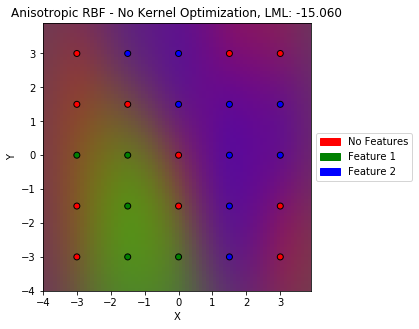

In [57]:
# test kernel optimization
kernel = 1.0 * RBF([1.0, 1.0])
test_gp(kernel, optimize=True, plot_dict=plot_dict, title="Anisotropic RBF - With Kernel Optimization")

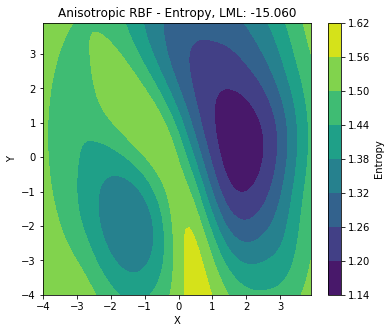

In [59]:
# test entropy plot
kernel = 1.0 * RBF([1.0, 1.0])
test_gp(kernel, optimize=True, plot_dict=plot_dict, title="Anisotropic RBF - Entropy", entropy=True)

In [150]:
class BaseSampler:
    """
    This is a Base class of your sampling agent.
    In this problem set, you will extend this class by inherit this class and
    implement each method which is currently not implemented yet.
    
    When you instantiate this class as well as all the inherited child classes, you should provide
    following inputs.
    
    Inputs:
        - world_map: numpy array, shape = (N, 2), 2D grid map of the given world
        - science_map: numpy array, shape = (N, ), corresponding feature of each point in the world_map
        - belief_model: a GaussianProcess instance, the agent's belief model for the world_map
        - init_pose: numpy array, shape = (2, ), initial location of the agent
        - feature_stats: list of tuples (A, B), each element corresponds to each feature
            - A: float, mean of science reward for the feature
            - B: float, variance of science reward for the feature
        - budget: dict, keys = {'distance', 'sampling'}
            - budget['distance']: float, the agent's distance budget
            - budget['sampling']: int, the agent's sampling budget
        - horizon (optional): float, the agent's reachable range
        - beta (optional): float, the agent's balancing factor for science reward and information gain
    
    """
    
    def __init__(self, world_map, science_map, belief_model, init_pose, feature_stats, budget, horizon=3.0, beta=0.5):
        self.world_map = world_map
        self.science_map = science_map
        self.model = belief_model
        self.pose = init_pose
        self.feature_stats = feature_stats

        # sampling hyper-parameters
        self.beta = beta
        self.horizon = horizon
        self.distance_budget = budget['distance']
        self.sampling_budget = budget['sampling']

        self.total_reward = 0
        self.points_traveled = deque([self.pose])
    
    def sample_only_explore(self, points):
        raise NotImplementedError

    def sample_explore_exploit(self, points):
        raise NotImplementedError

    def update_belief(self, new_sample):
        raise NotImplementedError

    def movement_cost(self, point):
        raise NotImplementedError
        
    def pick_next_point(self):
        raise NotImplementedError

    def start_explore(self):
        raise NotImplementedError
    
    def _get_points_from_horizon(self, points):
        """
        This is a method to obtain M reachable points from the agent's current position.
        You need to provide `points` argument that has a collection of N 2D-points among which
        the method looks for all the reachable points.
        
        Inputs:
            - points: numpy array, shape = (N, 2)
        Outputs:
            - points_around: numpy array, shape = (M, 2)
        """
        
        look_horizon = min([self.distance_budget, self.horizon])
        points_around = points[np.all(points != self.pose, axis=1)]
        tree = KDTree(points_around)
        ind = tree.query_radius(self.pose.reshape([1, -1]), r=look_horizon)[0]
        return points_around[ind]

    def _query_feature(self, point):
        """
        This is a method to obtain feature of a given point.
        
        Inputs:
            - point: numpy array, shape = (2, )
        Outputs:
            - feature: scalar
        """
        
        feature = self.science_map[np.all(self.world_map == point, axis=1)]
        return feature
    
        def sample_only_exploit(self, points):
        likelihoods = self.model.predict_proba(points)
        means = np.sum(likelihoods * np.array(self.feature_stats)[:, 0], axis=1)

        best_idx = np.argmax(means)
        best_sample_loc = points[best_idx]
        best_mean = np.max(means)

        return best_sample_loc, best_mean


In [ ]:
class Sampler_1(BaseSampler):
    def __init__(self, world_map, science_map, belief_model, init_pose, feature_stats, budget, horizon=3.0, beta=0.5):
        super(Sampler_1, self).__init__()
        """
        Please do not change this initialization function. It might cause errors later.
        """
        
    def sample_only_exploit(self, points):
        """
        This is a method to compute the best point that has the biggest expected science reward among the query points.
        You can use Gaussian Process model in the sampler to calculate likelihoods of each feature for each point.
        
            e.g. likelihoods = self.model.predict_proba(point)
            (*Please be careful about the shape of input/output of the model.predict_proba() function!)
        
        As outputs, you need to return the best sampling location among the points and its corresponding expected science reward.
        
        Inputs:
            - points: numpy array, shape = (N, 2)
        Outputs:
            - best_sample_loc: numpy array, shape = (2, )
            - best_mean: scalar, biggest expected science reward among the points
        
        """
        
        "YOUR CODE HERE"
        raise NotImplementedError

In [ ]:
class Sampler_2(BaseSampler):
    def __init__(self, world_map, science_map, belief_model, init_pose, feature_stats, budget, horizon=3.0, beta=0.5):
        super(Sampler_2, self).__init__()
        """
        Please do not change this initialization function. It might cause errors later.
        """
        
    def sample_only_explore(self, points):
        """
        This is a method to compute the best point that has the largest entropy among the query points.
        You can use Gaussian Process model in the sampler to calculate likelihoods of each feature for each point.
        
            e.g. likelihoods = self.model.predict_proba(point)
            (*Please be careful about the shape of input/output of the model.predict_proba() function!)
        
        As outputs, you need to return the best sampling location among the points and its corresponding entropy.
        
        Inputs:
            - points: numpy array, shape = (N, 2)
        Outputs:
            - best_sample_loc: numpy array, shape = (2, )
            - max_entropy: scalar, largest entropy among the points
        
        """
        
        "YOUR CODE HERE"
        raise NotImplementedError

In [ ]:
class Sampler_3(BaseSampler):
    def __init__(self, world_map, science_map, belief_model, init_pose, feature_stats, budget, horizon=3.0, beta=0.5):
        super(Sampler_1, self).__init__()
        """
        Please do not change this initialization function. It might cause errors later.
        """
        
    def sample_explore_exploit(self, points):
        """
        This is a method to compute the best point that trades off the biggest expected science reward and the largest entropy among the query points.
        You can use Gaussian Process model in the sampler to calculate likelihoods of each feature for each point.
        
            e.g. likelihoods = self.model.predict_proba(point)
            (*Please be careful about the shape of input/output of the model.predict_proba() function!)
        
        To allow trade-off, recall the member variable self.beta that balances the science reward and information gain.
        As outputs, you need to return the best sampling location among the points and its corresponding combined reward.
        
        Inputs:
            - points: numpy array, shape = (N, 2)
        Outputs:
            - best_sample_loc: numpy array, shape = (2, )
            - max_reward: scalar, maximum balanced reward of both science and information gain
        
        """
        
        "YOUR CODE HERE"
        raise NotImplementedError

In [ ]:
class Sampler_4(BaseSampler):
    def __init__(self, world_map, science_map, belief_model, init_pose, feature_stats, budget, horizon=3.0, beta=0.5):
        super(Sampler_4, self).__init__()
        """
        Please do not change this initialization function. It might cause errors later.
        """
        
    def update_belief(self, new_sample):
        """
        This is a method to update the belief model of the sampler.
        You can call self.model.fit(X, y) again to update it.
        As outputs, you need to return the new training data X_new and y_new that have
        previous X_train and y_train, and X and y from the new_sample.
        
        Inputs:
            - new_sample: tuple (A, B)
                - A: numpy array, shape = (2, )
                - B: numpy array, shape = (1, )
        Outputs:
            - X_new: numpy array, shape = (N+1, 2)
            - y_new: numpy array, shape = (N+1, )
            
        Modifies:
            - self.model: a GaussianProcess instance, a belief model
        
        """
        
        "YOUR CODE HERE"
        raise NotImplementedError

In [ ]:
class Sampler_5(BaseSampler):
    def __init__(self, world_map, science_map, belief_model, init_pose, feature_stats, budget, horizon=3.0, beta=0.5):
        super(Sampler_5, self).__init__()
        """
        Please do not change this initialization function. It might cause errors later.
        """
        
    def movement_cost(self, point):
        """
        This is a method to compute cost of movement from the current position to a query point.
        Use euclidean distance for the cost.
        
        Inputs:
            - point: numpy array, shape = (2, )
        Outputs:
            - distance: scalar, euclidean distance between the sampler's pose and the query point.
        
        """
        
        "YOUR CODE HERE"
        raise NotImplementedError

In [ ]:
class Sampler_6(BaseSampler):
    def __init__(self, world_map, science_map, belief_model, init_pose, feature_stats, budget, horizon=3.0, beta=0.5):
        super(Sampler_6, self).__init__()
        """
        Please do not change this initialization function. It might cause errors later.
        """
        
    def pick_next_point(self):
        """
        This is a method to choose a next point to which the sampler is moving.
        Recall that the sampler has a limited range of movement - horizon. It also has distance budget as a constraint.
        You first need to compute all the reachable points from your location and then use the method `sample_explore_exploit`
        that you have implemented above to obtain the next point.
        
        Inputs:
            - NO INPUTS
        Outputs:
            - next_point: numpy array, shape = (2, ), next point to which the robot is moving
            - reward: scalar, balanced reward of the next_point
        
        """
        
        "YOUR CODE HERE"
        raise NotImplementedError
        
    def sample_explore_exploit(self, points):
        "Copy and paste the `sample_explore_exploit` method that you have implemented in Sampler_3."
        raise NotImplementedError

In [ ]:
class AdaptiveSampler(BaseSampler):
    def __init__(self, world_map, science_map, belief_model, init_pose, feature_stats, budget, horizon=3.0, beta=0.5):
        super(AdaptiveSampler, self).__init__()
        """
        Please do not change this initialization function. It might cause errors later.
        """
    
    def start_explore(self):
        """
        This is a main method of the sampler to explore the given world by using adaptive sampling!
        You ONLY need to implement a sampling/moving iteration loop because all the settings are
        initialied when you instantiate this class.
        You essentially have to do:
            - pick up next point and its corresponding reward
            - increment total reward
            - decrease distance budget
            - decrement sampling budget
            - update your current position
            - update your belief model
            - add a new location to the traveled list
        
        Inputs:
            - NO INPUTS
        Outputs:
            - NO OUTPUS
        Modifies:
            - self.model: a GaussianProcess instance, a belief model
            - self.pose: numpy array, shape = (2, ), the sampler's current position
            - self.total_reward: scalar, the sampler's internal accumulated reward
            - self.distance_budget: scalar, the sampler's internal distance budget
            - self.sampling_budget: scalar, the sampler's internal sampling budget
            - self.points_traveled: deque (list), the sampler's explored points (including the initial position)
        
        """
        
        "YOUR CODE HERE"
        raise NotImplementedError
    
    def sample_explore_exploit(self, points):
        "Copy and paste the `sample_explore_exploit` method that you have implemented in Sampler_3."
        raise NotImplementedError
        
    def pick_next_point(self):
        "Copy and paste the `pick_next_point` method that you have implemented in Sampler_6."
        raise NotImplementedError
        
    def update_belief(self):
        "Copy and paste the `update_belief` method that you have implemented in Sampler_4."
        raise NotImplementedError
        
    def movement_cost(self, points):
        "Copy and paste the `movement_cost` method that you have implemented in Sampler_5."
        raise NotImplementedError

In [382]:
# test explorer
def test_explorer(budget, horizon, beta):
    X, Y, Z = gen_gridded_space_DET(feature_dict, N=3)
    X_init, y_init = parse_map_for_GP(X, Y, Z)
    X, Y, Z = gen_gridded_space_DET(feature_dict, N=50)
    world_map, science_map = parse_map_for_GP(X, Y, Z)
    
    kernel = 1.0 * RBF([1.0, 1.0])
    optimize = True
    model = GaussianProcess(kernel, optimize, plot_dict)
    model.fit(X_init, y_init)
    model.plot_belief()
    
    init_pose = np.array([0, 0])
    explorer = AdaptiveSampling(world_map, science_map, model, init_pose, feature_stats, budget, horizon, beta)
    explorer.start_explore()
    return explorer

3.429701089859009


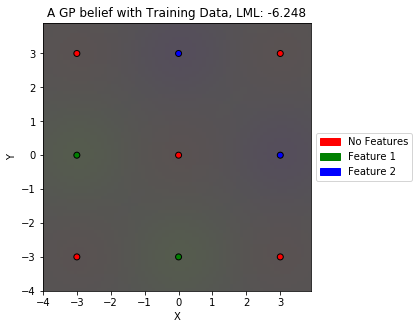

In [383]:
budget = {'distance': 100, 'sampling': 30}
horizon = 2
beta = 0.6
since = time.time()
explorer = test_explorer(budget, horizon, beta)
print(time.time() - since)

(<matplotlib.figure.Figure at 0x115ec89e8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x117aeb470>)

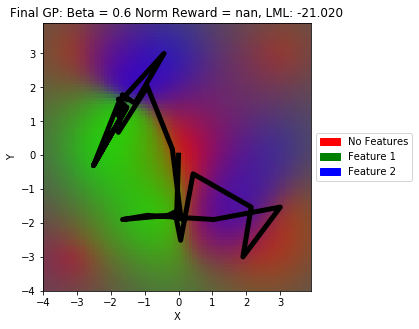

In [384]:
title = "Final GP: Beta = " + str(beta) + " Norm Reward = " + str(explorer.total_reward)
explorer.model.plot_belief(title, plotData=False, linePlot=np.array(explorer.points_traveled))

In [53]:
world_map

array([[-3.        , -3.        ],
       [-2.87755102, -3.        ],
       [-2.75510204, -3.        ],
       ...,
       [ 2.75510204,  3.        ],
       [ 2.87755102,  3.        ],
       [ 3.        ,  3.        ]])